In [31]:
from gensim.models import Word2Vec
from Bio import SeqIO
import random
import numpy as np
import pandas as pd
from Bio import pairwise2
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


### Preprocessing

In [19]:

fasta_file = "data/ecoli.fasta"
# fasta_file = "data/chr10.fa"

sequence = ""
for record in SeqIO.parse(fasta_file, "fasta"):
    sequence += str(record.seq).upper()

print("Total length:", len(sequence))



Total length: 4641652


In [20]:

def split_sequence(seq, fragment_len=2000):
    return [seq[i:i+fragment_len] for i in range(0, len(seq), fragment_len)]

fragments = split_sequence(sequence, fragment_len=2000)
print("Fragments:", len(fragments), "Fragment[0] length:", len(fragments[0]))

Fragments: 2321 Fragment[0] length: 2000


In [21]:

def variable_kmers_random(fragment, k_choices=(3,4,5,6,8), seed=42):
    """Randomly pick a k from k_choices at each start position (if it fits)."""

    random.seed(seed)
    for i in range(len(fragment)):
        possible = [k for k in k_choices if i + k <= len(fragment)]
        if not possible:
            break
        k = random.choice(possible)
        yield fragment[i:i+k]  # return k-mer plus its k and position


In [22]:

context_size = 20
sentences = []


for frag_idx, frag in enumerate(fragments):
    kmers_list = list(variable_kmers_random(frag))
    # chunk into non-overlapping sentences
    for i in range(0, len(kmers_list) - context_size + 1, context_size):
        sentences.append(kmers_list[i:i+context_size])

    if (frag_idx + 1) % 400 == 0:
        print(f"Processed fragments: {frag_idx+1}/{len(fragments)} | sentences so far: {len(sentences)}")

print("Total sentences:", len(sentences))
print("Example sentence (len):", len(sentences[0]), sentences[0][:5])

Processed fragments: 400/2321 | sentences so far: 39600
Processed fragments: 800/2321 | sentences so far: 79200
Processed fragments: 1200/2321 | sentences so far: 118800
Processed fragments: 1600/2321 | sentences so far: 158400
Processed fragments: 2000/2321 | sentences so far: 198000
Total sentences: 229762
Example sentence (len): 20 ['AGC', 'GCT', 'CTTTT', 'TTTT', 'TTTC']


### Prepare the model

In [23]:


model = Word2Vec(
    sentences,
    vector_size=100,
    window=10,        # context window inside each sentence
    sg=1,            # skip-gram
    min_count=1,
    workers=4,
    epochs=50
)

model.save("dna2vec.model")
print("Vocabulary size:", len(model.wv))
print("Vector sample:", model.wv[sentences[0][0]][:5])

Vocabulary size: 69577
Vector sample: [ 0.31258726  0.20603217  0.21954685 -0.21111268 -0.23443723]


In [24]:
#load the saved model
# model = Word2Vec.load("dna2vec.model")

### Evaluation Metric

In [25]:


def embed_sequence(seq, k_choices=(3,4,5,6,8), seed=42):
    """Embed a sequence by averaging embeddings of k-mers sampled by variable_kmers_random."""
    vecs = []
    for kmer in variable_kmers_random(seq, k_choices=k_choices, seed=seed):
        if kmer in model.wv:
            vecs.append(model.wv[kmer])
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)


def evaluate_pair(seq_a, seq_b):
    va, vb = embed_sequence(seq_a), embed_sequence(seq_b)
    cos_sim = 1 - cosine(va, vb)
    aln_score = pairwise2.align.globalxx(seq_a, seq_b, score_only=True)
    return cos_sim, aln_score

In [26]:

random.seed(42)
seq_len = 40  

i = random.randint(0, len(sequence) - seq_len)
j = random.randint(0, len(sequence) - seq_len)

seq1 = sequence[i:i+seq_len]
seq2 = sequence[j:j+seq_len]

cos_sim_1, aln_score_1 = evaluate_pair(seq1, seq2)

print("Random pair indices:", (i, j))
print("Seq1:", seq1[:50])
print("Seq2:", seq2[:50])
print("Cosine similarity:", cos_sim_1)
print("Alignment score:", aln_score_1)

Random pair indices: (933912, 209805)
Seq1: ACAGCATGAATCACGCCGTGCCCGTATTCTTCGCGGCGCG
Seq2: TGAAATTTATCGAGCATAACCCTCGAATTTGCGGCGTGAT
Cosine similarity: 0.7823962
Alignment score: 26.0


### Calculate correlation

In [27]:

pair_count = 100
seq_len = 40

pairs = [(random.randint(0, len(sequence)-seq_len),
          random.randint(0, len(sequence)-seq_len)) for _ in range(pair_count)]

cos_sims = []
aln_scores = []

for a_idx, b_idx in pairs:
    sa = sequence[a_idx:a_idx+seq_len]
    sb = sequence[b_idx:b_idx+seq_len]
    c, a = evaluate_pair(sa, sb)
    cos_sims.append(c)
    aln_scores.append(a)

r, p = pearsonr(cos_sims, aln_scores)
print("Pairs evaluated:", pair_count)
print("Pearson r:", r, "p-value:", p)

Pairs evaluated: 100
Pearson r: 0.4263881586951517 p-value: 9.718452049348906e-06


In [40]:
rows = []
for i, (a_idx, b_idx) in enumerate(pairs):
    sa = sequence[a_idx:a_idx+seq_len]
    sb = sequence[b_idx:b_idx+seq_len]
    rows.append({
        "sa": sa,
        "sab": sb,                 # sb as 'sab' per request
        "cos_sim": round(float(cos_sims[i]),4),
        "aln_scores": float(aln_scores[i])
    })

results_df = pd.DataFrame(rows)
top10_by_cos = results_df.sort_values(by="cos_sim", ascending=False).head(10).reset_index(drop=True)
display(top10_by_cos)

# Opt

,sa,sab,cos_sim,aln_scores
0,TGGGTCATGAACAACTCACTGAGCGATTTCGACTTACCGT,GCGCGTCAAAGTCACTGGCAACCCAGGTACATTTCACCTG,0.8485,27.0
1,GTCACCGGAAAATCAGAGCCTGGCGAGTAAAGTTGGCGGC,ATCCCGCGGTGCGTACGCCGCTGGAGTGGCGTCAGGCGAT,0.8360,26.0
2,GTTTTCCTTCATCATATTTCAGGCTAAGGTGATCGCCTTA,AGCAGGTCATCAGGGGTGATTTCAGGATCGTAGATAAAGG,0.8238,24.0
3,CGCACAGGCGCTGGTCGCTAAAGGCATCACCATTGAGTTG,CGAACCGGGCGCGCTGGCCCCACTGATGGATAAAGGCGAG,0.8198,26.0
4,ATCTCGCATGGACGAAATAAGCTCCTTGAATTGGCGGGGA,TCATCCGCGGATAAAACTGCCAGAAGCGGGTTTCGAGGGC,0.8178,27.0
5,GCTGCTGGATACGCTGGACGCACTGGCAGAGTACCAACGC,AGTGGGCGGCAGGCAAAAACGATATCGGCTGGTACTCGCT,0.8157,26.0
6,GCCGTTTACGCGCAGCCCAGAGCGATGAAGAGCTGTATCA,ACGATGGCAACCAGAGAAACCGCCTTCTGTGCCTGTTCCA,0.8144,25.0
7,GCGATCGCGTACTGGGTCGTGTAACTGCTGAAGACGTTCT,GATCCCTCGTCGTGCCATGGAATACGGCGCGGAGAACGCA,0.8055,26.0
8,AGTGACATTATCGCTGTTAACGCGGTTCTGATGACGCTAC,CTCCGAAATAATCTGTAGGCTATGGTGAAGCACTTCAATA,0.8045,25.0
9,ACAGTTTTTCGTCGACACCGGAAGAGAGGATCACCCATGG,CGTGCATCGGCTGGCCCAGTTCGAGCAGCACATAGTTGGT,0.8032,24.0


In [37]:
avg_sim = float(np.mean([c for c in cos_sims if np.isfinite(c)]))
avg_aln = float(np.mean([a for a in aln_scores if np.isfinite(a)]))
print(f"Average sim score: {avg_sim:.4f}")
print(f"Average aln score: {avg_aln:.4f}")

Average sim score: 0.7449
Average aln score: 23.9500


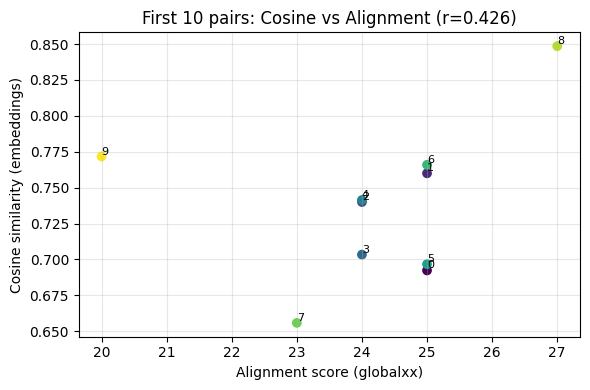

In [28]:

first_n = 10
x = aln_scores[:first_n]
y = cos_sims[:first_n]

plt.figure(figsize=(6,4))
plt.scatter(x, y, c=range(first_n), cmap="viridis")
for idx in range(first_n):
    plt.text(x[idx], y[idx], str(idx), fontsize=8, ha='left', va='bottom')
plt.xlabel("Alignment score (globalxx)")
plt.ylabel("Cosine similarity (embeddings)")
plt.title(f"First {first_n} pairs: Cosine vs Alignment (r={r:.3f})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()